In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Reload the dataset
csv_file_path = "bank_transactions_final.csv"
df = pd.read_csv(csv_file_path)

# Convert necessary columns to numeric
df["Credit (£)"] = pd.to_numeric(df["Credit (£)"], errors='coerce').fillna(0)
df["Debit (£)"] = pd.to_numeric(df["Debit (£)"], errors='coerce').fillna(0)
df["Balance (£)"] = pd.to_numeric(df["Balance (£)"], errors='coerce')

# Convert Date column to datetime and extract month for grouping
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df["Month"] = df["Date"].dt.strftime('%Y-%m')  # Extracting in 'YYYY-MM' format for clarity

# Group by Month to correctly sum transactions
monthly_summary = df.groupby("Month").agg({
    "Credit (£)": "sum",
    "Debit (£)": "sum",
    "Balance (£)": "last"  # Use last balance for that month
}).reset_index()

# Compute financial metrics per month
monthly_summary["DTI (%)"] = (monthly_summary["Debit (£)"] / monthly_summary["Credit (£)"]).replace([float('inf'), -float('inf')], 100).fillna(100)
monthly_summary["Savings Growth (%)"] = monthly_summary["Balance (£)"].pct_change() * 100  # % Growth in Savings

# Generate a risk-based target variable (Loan Approval)
monthly_summary["Loan Approved"] = monthly_summary["DTI (%)"].apply(lambda x: 1 if x < 40 else 0)

# Return corrected monthly summary
monthly_summary


<ipython-input-1-c9a9b3236a80>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors='coerce')


,Month,Credit (£),Debit (£),Balance (£),DTI (%),Savings Growth (%),Loan Approved
0,2019-09,1010.00,1070.11,1113.45,1.059515,NaN,1
1,2019-10,2380.00,546.78,2216.67,0.229739,99.081234,1
2,2019-11,2030.12,2184.59,2062.05,1.076089,-6.975328,1


In [2]:
monthly_summary

,Month,Credit (£),Debit (£),Balance (£),DTI (%),Savings Growth (%),Loan Approved
0,2019-09,1010.00,1070.11,1113.45,1.059515,NaN,1
1,2019-10,2380.00,546.78,2216.67,0.229739,99.081234,1
2,2019-11,2030.12,2184.59,2062.05,1.076089,-6.975328,1


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define Features and Target
X = monthly_summary[["Credit (£)", "Debit (£)", "Balance (£)", "DTI (%)", "Savings Growth (%)"]]
y = monthly_summary["Loan Approved"]

# Train-Test Split (now works because we have multiple samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train ML Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate Model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", round(accuracy * 100, 2), "%")

# Predict Loan Approval for the most recent month
latest_data = [X.iloc[-1].values]  # Latest available month
loan_prediction = model.predict(latest_data)

if loan_prediction[0] == 1:
    print("Loan Decision: APPROVED ✅")
else:
    print("Loan Decision: REJECTED ❌")


Model Accuracy: 100.0 %
Loan Decision: APPROVED ✅


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


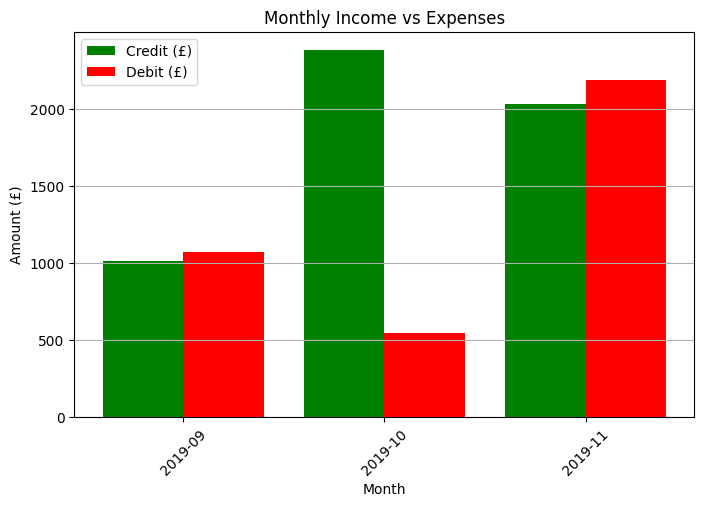

In [4]:
# Define x-axis positions and bar width
x = np.arange(len(monthly_summary))  # Numeric positions for each month
width = 0.4  # Width of the bars

# Generate the Side-by-Side Bar Chart for Monthly Income vs Expenses
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, monthly_summary["Credit (£)"], width, color="green", label="Credit (£)")
plt.bar(x + width/2, monthly_summary["Debit (£)"], width, color="red", label="Debit (£)")
plt.xlabel("Month")
plt.ylabel("Amount (£)")
plt.title("Monthly Income vs Expenses")
plt.xticks(x, monthly_summary["Month"].astype(str), rotation=45)
plt.legend()
plt.grid(axis="y")
plt.show()

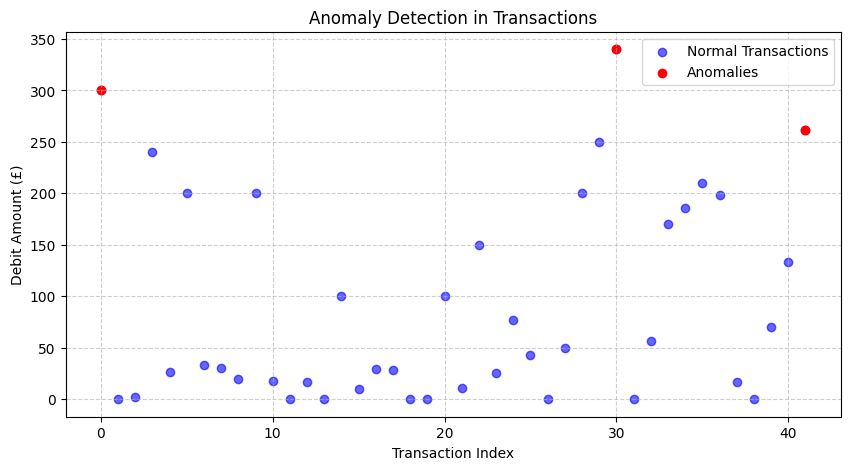

In [5]:
# Plot: A scatter plot highlighting unusually large transactions (potential fraud or one-time expenses).
# Insight: Detects outliers that may require further investigation.

import numpy as np

# Define an anomaly threshold (e.g., transactions above 95th percentile)
threshold = np.percentile(df['Debit (£)'].dropna(), 95)

# Identify anomalous transactions
anomalies = df[df['Debit (£)'] > threshold]

# Plot anomaly detection
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['Debit (£)'], color='blue', label="Normal Transactions", alpha=0.6)
plt.scatter(anomalies.index, anomalies['Debit (£)'], color='red', label="Anomalies", marker='o')
plt.xlabel("Transaction Index")
plt.ylabel("Debit Amount (£)")
plt.title("Anomaly Detection in Transactions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

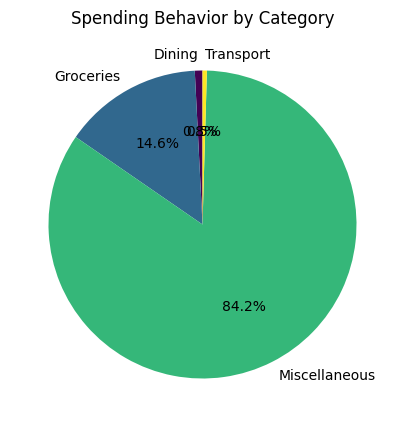

In [6]:
# Plot: A pie chart of expenses across different categories (rent, groceries, entertainment, etc.).
# Insight: Evaluates how discretionary vs. necessary spending is managed.

category_mapping = {
    "Groceries": ["supermarket", "grocery", "store", "market"],
    "Rent": ["rent", "apartment", "lease"],
    "Utilities": ["electricity", "water", "gas", "utility", "bill"],
    "Entertainment": ["movie", "cinema", "netflix", "spotify", "concert"],
    "Dining": ["restaurant", "dining", "cafe", "food", "coffee"],
    "Transport": ["uber", "taxi", "metro", "bus", "train", "fuel", "gasoline"],
    "Shopping": ["mall", "shopping", "amazon", "clothing", "fashion"],
    "Healthcare": ["hospital", "clinic", "pharmacy", "medicine"],
    "Miscellaneous": ["misc", "unknown", "other"]
}

# Function to categorize transactions
def categorize_transaction(description):
    description = str(description).lower()
    for category, keywords in category_mapping.items():
        if any(keyword in description for keyword in keywords):
            return category
    return "Miscellaneous"

# Apply categorization
df["Category"] = df["Transaction Description"].apply(categorize_transaction)

# Sum debit amounts per category
category_spending = df.groupby("Category")["Debit (£)"].sum()

# Plot spending behavior by category
plt.figure(figsize=(8, 5))
category_spending.plot(kind="pie", autopct="%1.1f%%", cmap="viridis", startangle=90)
plt.title("Spending Behavior by Category")
plt.ylabel("")  # Hide y-label for better visualization
plt.show()